In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,Dense, MaxPooling1D, Flatten, Activation, Conv1D, Dropout, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import seaborn as sns


Data = pd.read_csv('/Users/sergiomares/The_table.txt',sep = ' ',  header = None)
Cpg_Islands = pd.read_csv('/Users/sergiomares/Enero162022/coordiantes.txt', header = 0, sep= '\t' )

from math import sqrt

Data.columns = ['Gene','CRISPRoff_average','mutant_average','NaN','Sequence']

for i in range(len(Data)):

    if Data['mutant_average'][i] > Data['CRISPRoff_average'][i]:
        Data.at[i, 'Phe_sco_pos_neg'] =  int(1)
        Data.at[i,'Strength'] =  sqrt(abs(Data['mutant_average'][i] - Data['CRISPRoff_average'][i])) 

    elif Data['mutant_average'][i] < Data['CRISPRoff_average'][i]:
        Data.at[i, 'Phe_sco_pos_neg'] = int(0)
        Data.at[i,'Strength'] = 0
    else:
        Data.at[i, 'Strength'] = 'Same'

from tensorflow.keras import backend as K
K.clear_session()


In [2]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x
# tf.set_random_seed(seed_value) # tensorflow 1.x

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

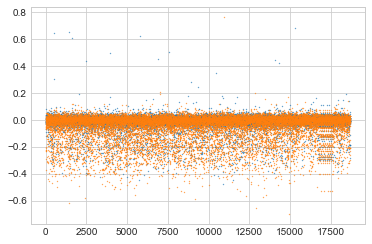

In [22]:
import numpy as np
import matplotlib.pyplot as plt


plt.scatter(Data['index'],Data['mutant_average'], s = 0.1)
plt.scatter(Data['index'],Data['CRISPRoff_average'], s = 0.1)
plt.show()

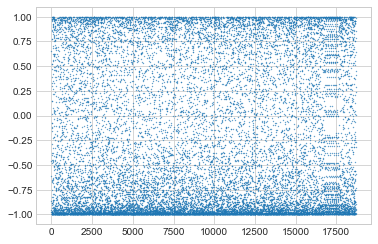

In [51]:
from sklearn import preprocessing

normalized1 = preprocessing.normalize(Data[['CRISPRoff_average','mutant_average']])
scaled_df = pd.DataFrame(normalized1, columns=['CRISPRoff_average','mutant_average'])
scaled_df.head()

plt.scatter( x = Data['index'], y = scaled_df['CRISPRoff_average'] , s = 0.1)

#plt.scatter( x = Data['index'], y = scaled_df['mutant_average'] , s = 1)
plt.show()

In [363]:
Data['CpG'] = 0

for i in range(18694):
    if Cpg_Islands['CpG'].loc[Cpg_Islands['gene'] == Data['Gene'][i]].iloc[0] == 'VERDADERO':
        Data['CpG'][i] = 1
        #print(1)
    else:
        Data['CpG'][i] = 0
        #print(0)

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_55872/1352674810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['CpG'][i] = 0
/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_55872/1352674810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['CpG'][i] = 1


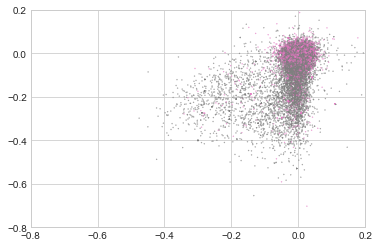

In [365]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:grey', 0:'tab:pink'}

plt.scatter(Data['mutant_average'], Data['CRISPRoff_average'], c = Data['CpG'].map(colors)
         , s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])

plt.savefig('good.eps', format = 'eps')


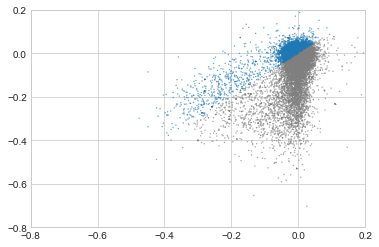

In [340]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:grey', 0:'tab:blue'}

plt.scatter(Data['mutant_average'], Data['CRISPRoff_average'], c = Data['Phe_sco_pos_neg'].map(colors)
         , s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])

plt.savefig('good.eps', format = 'eps')


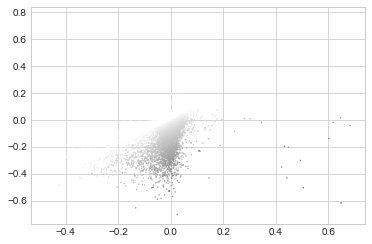

In [339]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

colors = {1:'tab:grey', 0:'tab:blue','Same':'tab:red'}

plt.scatter(Data['mutant_average'], Data['CRISPRoff_average'], c = Data['Strength']
         , s = 0.1)

plt.savefig('good.eps', format = 'eps')


In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

sequences = Data['Sequence'][:]

 # This removes empty sequences.

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

counter = 0 
for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AAATATATTT ... GAATAACTCT
One hot encoding of Sequence #1:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, Data[['mutant_average','CRISPRoff_average']], test_size=0.25, random_state=42)

In [16]:
model_in = Input(shape=(train_features[1].shape))
model = (Conv1D(filters = 64, kernel_size = 32, activation = 
'tanh', padding = 'valid'))(model_in)

model1 = (MaxPooling1D(pool_size=(4)))(model)
model1 = (Dense(16, activation='relu'))(model1)
model1 = GlobalMaxPool1D()(model1)
model1 = (Dense(1, activation='linear'))(model1)

model2 = (MaxPooling1D(pool_size=(4)))(model)
model2 = (Dense(16, activation='relu'))(model2)
model2 = GlobalMaxPool1D()(model2)
model2 = (Dense(1, activation='linear'))(model2)


model = Model(model_in, [model1,model2])
model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])

tf.random.set_seed(0)
history = model.fit(train_features, [train_labels['mutant_average'], train_labels['CRISPRoff_average']], epochs = 50, batch_size=50, verbose=0, validation_split=0.25)
    


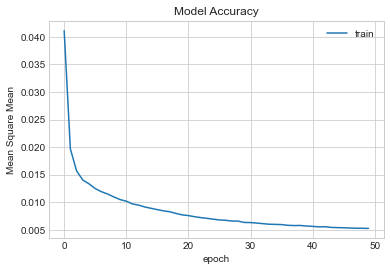

In [348]:
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Mean Square Mean')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('model-epochs.eps', format = 'eps')

In [17]:
history.history

{'loss': [0.04111257940530777,
  0.019655302166938782,
  0.015676097944378853,
  0.01401556096971035,
  0.013325917534530163,
  0.012467678636312485,
  0.011898658238351345,
  0.011474689468741417,
  0.010943591594696045,
  0.01047094352543354,
  0.01017768494784832,
  0.009673620574176311,
  0.009460262022912502,
  0.009119706228375435,
  0.00888052862137556,
  0.008641530759632587,
  0.008418544195592403,
  0.008255789056420326,
  0.007950746454298496,
  0.007692496292293072,
  0.007562596350908279,
  0.007358338683843613,
  0.007193803787231445,
  0.007062394637614489,
  0.006908230017870665,
  0.006770957261323929,
  0.006705169565975666,
  0.006572232581675053,
  0.006560391280800104,
  0.0063148909248411655,
  0.006296807434409857,
  0.006203066557645798,
  0.006098136305809021,
  0.0059925829991698265,
  0.00596666568890214,
  0.005925907287746668,
  0.005798113066703081,
  0.005752147175371647,
  0.005767425522208214,
  0.005668858997523785,
  0.005603897850960493,
  0.00551552

In [249]:
model.layers

In [1014]:
#maxo
def make_gradients(list, layer1, layer2):

  conta = len(list)

  a = model.layers[layer1] #0 and 3 --> 2500 bp
  b = model.layers[layer2]
  print(a,b)

  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(a.variables)  # Since `a.build` has not been called at this point
                            # `a.variables` will return an empty list and the
                            # tape will not be watching anything.
    result = b(a(test_features[[list]]))
    tape.gradient(result, a.variables)

  flata = []
  [flata.append(result.numpy()[i].flatten()) for i in range(conta)]

  print('The shape of the sequence array is', flata[0].shape)

  return flata

def generate__stack_figure(flata, list):
  a = len(flata)
  b = 0
  plt.figure(figsize=[16,5])

  colors = {'A':'b', 'G':'tab:green','T':'tab:grey', 'C':'tab:red'}
  while(b != a):
    barlist = plt.bar(np.arange(len(flata[b][:2500])), flata[b][:2500], color =[colors[r] for r in sequences[list[b]][:2500]])
    b += 1 
  
  plt.xlabel('Bases')
  plt.ylabel('Magnitude of saliency values')
  plt.axis([0,2500,-1,1])
  markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
  plt.legend(markers, colors.keys(), numpoints=1)
  plt.title('Saliency map for bases in one of the  sequences');


def generate_single_figure(flata, lists,length):
  a = len(lists)
  for i in range(a):
    plt.figure(figsize=[16,5])

    colors = {'A':'b', 'G':'tab:green','T':'tab:grey', 'C':'tab:red'} 
    plt.bar(np.arange(len(flata[i][:length])), flata[i][:length], color =[colors[r] for r in sequences[lists[i]][:length]])
    plt.xlabel('Bases')
    plt.ylabel('Magnitude of saliency values')
    plt.axis([0,length,-1,1])

    if length < 200:
      plt.xticks(np.arange(len(flat[:length])), list(sequences[lists[i]][:length]));

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
    plt.legend(markers, colors.keys(), numpoints=1)
    plt.title('Saliency map for bases in one of the  sequences');

def GC_content(gradients, sequences_index):
  averages = []
  gradient_total = len(gradients)
  for x in range(gradient_total):
    gc = 0 
    neurons_fired = 0
    for index, binary in enumerate([i if (i > 0) else 0 for i in gradients[x]]):
        if binary > 0:
          neurons_fired += 1 
        if binary > 0 and sequences[sequences_index[x]][index] == ('G'):
                gc += 1
        elif binary > 0 and sequences[sequences_index[x]][index] == ('C'):
                gc += 1
              
    content = gc/neurons_fired * 100
    averages.append(content)
  
  avg_cg = sum(averages)/gradient_total
  print('From the', neurons_fired,'neurons fired, there was an average of',avg_cg,"%","content")
  return (averages)


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_55872/1819648053.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = b(a(test_features[[list]]))


The shape of the sequence array is (2500,)
From the 1632 neurons fired, there was an average of 45.796543823017494 % content
The shape of the sequence array is (2500,)
From the 1630 neurons fired, there was an average of 46.839507076472316 % content


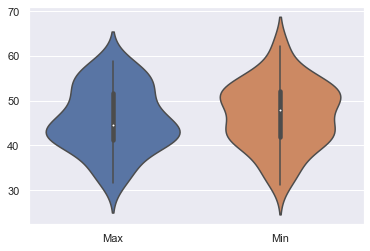

In [981]:
maxlist = test_labels['mutant_average'].sort_values().head(50).index
minlist = test_labels['mutant_average'].sort_values().tail(50).index

cont_max = GC_content(make_gradients(maxlist,0,3), maxlist)
cont_min = GC_content(make_gradients(minlist,0,3), minlist)

conts = pd.DataFrame()
conts['Max'], conts['Min'] = pd.DataFrame(cont_max), pd.DataFrame(cont_min)
conts

sns.set_theme(style="darkgrid")
sns_plot = sns.violinplot(data = conts, split = True)
sns_plot.figure.savefig("output.png")

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_55872/1819648053.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = b(a(test_features[[list]]))


The shape of the sequence array is (2500,)
From the 1603 neurons fired, there was an average of 45.28043544789043 % content
The shape of the sequence array is (2500,)
From the 1604 neurons fired, there was an average of 50.2303137538587 % content


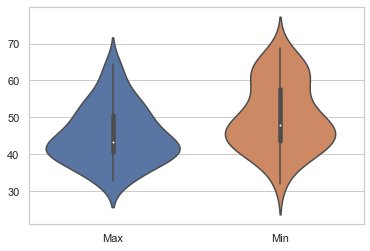

In [982]:
maxlist = test_labels['CRISPRoff_average'].sort_values().head(50).index
minlist = test_labels['CRISPRoff_average'].sort_values().tail(50).index

cont_max = GC_content(make_gradients(maxlist,0,3), maxlist)
cont_min = GC_content(make_gradients(minlist,0,3), minlist)

conts = pd.DataFrame()
conts['Max'], conts['Min'] = pd.DataFrame(cont_max), pd.DataFrame(cont_min)
conts

sns.set_theme(style="whitegrid")
sns_plot = sns.violinplot(data = conts, split = True)
sns_plot.figure.savefig("output.png")

In [1047]:
make_gradients(maxlist,1,5)

<keras.layers.convolutional.Conv1D object at 0x17de800a0> <keras.layers.core.Dense object at 0x17e3f5880>


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_55872/2619969659.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = b(a(test_features[[list]]))


The shape of the sequence array is (39520,)


[array([0.        , 0.        , 0.        , ..., 0.        , 0.05414747,
        0.        ], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00586577], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.62573016, 0.        ,
        0.2105895 ], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.21143614,
        0.1895706 ], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.20202386, 0.        ,
        0.2151691 ], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.56734985, 0.        ,
        0.        ], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.24765691, 0.        ,
        0.8224562 ], dtype=float32),
 array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.5063585], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.7181433 , 0.00908471,

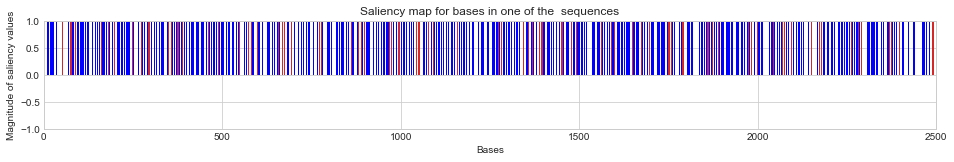

In [654]:
#mino

a = model.layers[0] #0 and 3 --> 2500 bp
b = model.layers[3]


with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(a.variables)  # Since `a.build` has not been called at this point
                           # `a.variables` will return an empty list and the
                           # tape will not be watching anything.
  result = b(a(test_features[3265:3266]))
  tape.gradient(result, a.variables)

result.shape

flat = result.numpy()[0].flatten()
plt.figure(figsize=[16,2])
#plt.figure(figsize=[16,5])

colors = {'A':'b', 'G':'tab:red','T':'b', 'C':'tab:red'}
colors_1 = ['A', 'G','T', 'C']


barlist = plt.bar(np.arange(len(flat[:2500])), flat[:2500], color =[colors[r] for r in sequences[0][:100]])
#[barlist[i].set_color('C1') for i in range(1,99)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.axis([0,2500,-1,1])
#plt.xticks(np.arange(len(flat[:2500])), list(sequences[0][:2500]));
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
#plt.legend(markers, colors.keys(), numpoints=1)
plt.title('Saliency map for bases in one of the  sequences');
plt.savefig('sliency.eps', format = 'eps')


In [360]:
predicted[0][4673]

array([0.03621254], dtype=float32)

In [356]:
test_labels

,mutant_average,CRISPRoff_average
17032,0.000070,0.023336
651,-0.005278,0.009618
9827,-0.002709,-0.003177
10735,-0.018460,0.011882
17554,0.013992,-0.054588
...,...,...
10676,-0.016615,-0.060150
14050,-0.163932,-0.061303
18113,0.006338,-0.009435
14863,-0.017681,-0.035767


In [362]:
test_labels = test_labels.reset_index()
predicted_values = pd.DataFrame()
predicted_values[0], predicted_values[1] = pd.DataFrame(predicted[0]), pd.DataFrame(predicted[1])

values = (0, 0)

a = len(predicted_values)

for i in range(a):
    temp =  (abs(predicted_values[0][i]) - abs(test_labels['mutant_average'][i]))  /abs(test_labels['mutant_average'][i]) * 100
    temp2 = (abs(predicted_values[1][i]) - abs(test_labels['CRISPRoff_average'][i]) )/abs(test_labels['CRISPRoff_average'][i]) * 100
    values = values[0] + temp, values[1] + temp2

values =  values[0]/a, values[1]/a

values


(532.0089541444986, 1340.3853971990225)

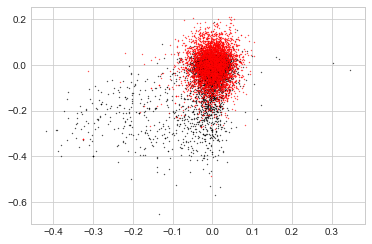

In [344]:
predicted = model.predict(test_features)

plt.scatter(test_labels['mutant_average'], test_labels['CRISPRoff_average'], c='black',s = 0.1)
plt.scatter(predicted[0], predicted[1], c='red',s = 0.1)
plt.show()
plt.savefig('predicted_model.eps', format = 'eps')


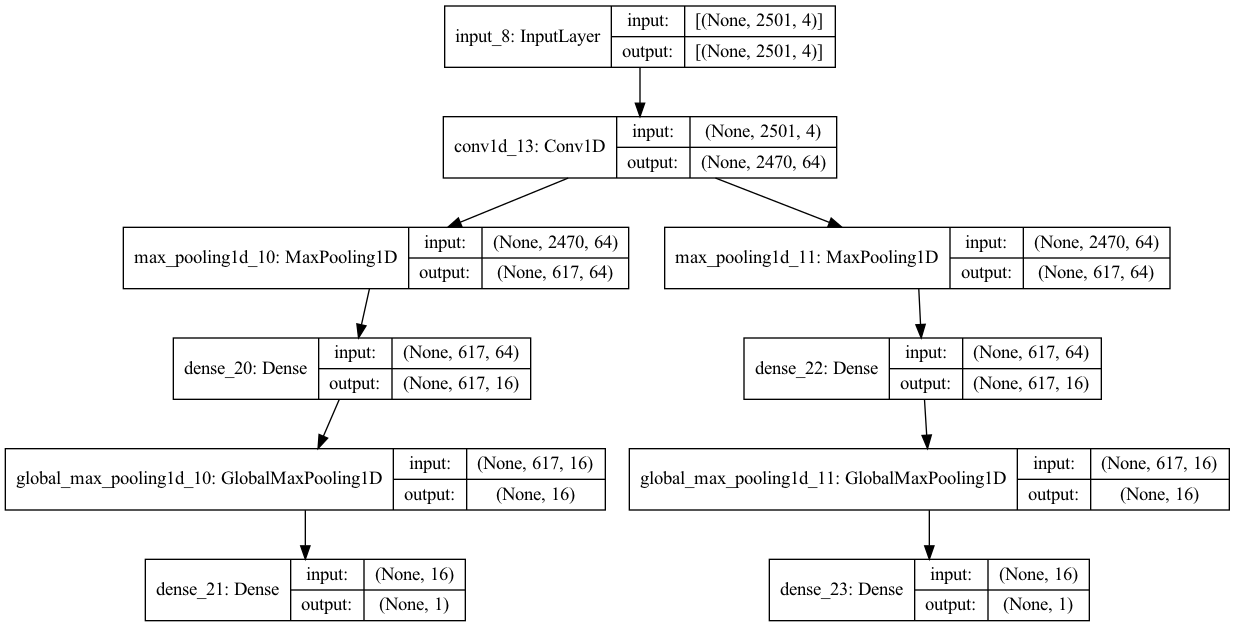

In [341]:
from keras.utils.vis_utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)

In [11]:
import tensorflow as tf

def build_model(list):
    model_in = Input(shape=(train_features[1].shape))
    model = (Conv1D(filters = list[0], kernel_size = list[1], activation = 
'tanh', padding = 'valid'))(model_in)

    model1 = (Conv1D(filters = list[2], kernel_size = list[3], activation ='tanh'))(model)
    model1 = (MaxPooling1D(pool_size=(list[4])))(model1)
    model1 = (Dense(list[5], activation='relu'))(model1)
    model1 = GlobalMaxPool1D()(model1)
    model1 = (Dense(1, activation='linear'))(model1)

    model2 = (Conv1D(filters = list[2], kernel_size = list[3], activation ='tanh'))(model)
    model2 = (MaxPooling1D(pool_size=(list[4])))(model2)
    model2 = (Dense(list[5], activation='relu'))(model2)
    model2 = GlobalMaxPool1D()(model2)
    model2 = (Dense(1, activation='linear'))(model2)
    
    # model1 = (Conv1D(filters = list[2], kernel_size = list[3]))(model)
    # model1 = (MaxPooling1D(pool_size=(list[4])))(model1)
    # model1 =(Dense(list[5], activation='LeakyReLU'))(model1)
    # model1 = GlobalMaxPool1D()(model1)
    # model1 = (Dense(1, activation='LeakyReLU'))(model1)
    # #model1 = Activation('softmax')(model1)

    # model2 = (Conv1D(filters = list[2], kernel_size = list[3]))(model)
    # model2 = (MaxPooling1D(pool_size=(list[4])))(model2)
    # model2 =(Dense(list[5], activation='LeakyReLU'))(model2)
    # model2 = GlobalMaxPool1D()(model2)
    # model2 = (Dense(1, activation='LeakyReLU'))(model2)
    # #model2 = Activation('softmax')(model2)

    model = Model(model_in, [model1,model2])
    model.compile(loss='MeanSquareError',optimizer='rmsprop', metrics=['accuracy'])

    return model

def run_model(model):
    
    tf.random.set_seed(0)
    history = model.fit(train_features, [train_labels['mutant_average'], train_labels['CRISPRoff_average']], epochs = 50, batch_size=50, verbose=0, validation_split=0.25)
    predicted = model.predict(test_features)

    return(predicted)

def average_percentage_error(predicted, test_labels):
    test_labels = test_labels.reset_index()
    predicted_values = pd.DataFrame()
    predicted_values[0], predicted_values[1] = pd.DataFrame(predicted[0]), pd.DataFrame(predicted[1])

    values = (0, 0)

    a = len(predicted_values)

    for i in range(a):
        temp =  (abs(predicted_values[0][i]) - abs(test_labels['mutant_average'][i]))  /abs(test_labels['mutant_average'][i]) * 100
        temp2 = (abs(predicted_values[1][i]) - abs(test_labels['CRISPRoff_average'][i]) )/abs(test_labels['CRISPRoff_average'][i]) * 100
        values = values[0] + temp, values[1] + temp2
    
    values =  values[0]/a, values[1]/a

    return values


def good_parameter(evaluation, previous_evaluation, parameter_list, index_of_parameter, best_list, best_list_eva):
        
    # New best list
    if evaluation[0] < best_list_eva[0] and evaluation[1] < best_list_eva[1]:
        best_list = parameter_list

        if index_of_parameter < 5:
            index_of_parameter += 1
        else:
            index_of_parameter = 0

        parameter_list[index_of_parameter] += 1 

        if parameter_list[index_of_parameter] == 0:
            parameter_list[index_of_parameter] += 1 

        return(parameter_list, index_of_parameter, evaluation, best_list, best_list_eva)

    #If new model is better than last one
    elif evaluation[0] < previous_evaluation[0] and evaluation[1] < previous_evaluation[1]:

        if index_of_parameter < 5:
            index_of_parameter += 1
        else:
            index_of_parameter = 0

        parameter_list[index_of_parameter] += 1 

        if parameter_list[index_of_parameter] == 0: 
            parameter_list[index_of_parameter] += 1 

        return(parameter_list, index_of_parameter, evaluation, best_list, best_list_eva)

    else:

        parameter_list = best_list
        parameter_list[index_of_parameter] -= 1

        if parameter_list[index_of_parameter] == 0: 
            parameter_list[index_of_parameter] += 1 
         
        if index_of_parameter < 5:
            index_of_parameter += 1
        else:
            index_of_parameter = 0

        parameter_list[index_of_parameter] += 1 

        return(best_list, index_of_parameter, evaluation, best_list, best_list_eva)


In [10]:
hp = [1, 16, 13, 2, 1, 8]
#hp = [1,4,8,2,1,6]
pe =  (10000, 10000)
bl = [3, 16, 13, 3, 1, 8]
bl_eva = (1000, 1000)

each_parameters = 0 

for so_many_models in range(1):   

    #return predicted model
    running = run_model(build_model(hp)) 

    #return evaluation of the model (2 values)
    #eva = average_percentage_error(running, test_labels)
    #print(hp, eva) 

    # plt.scatter(test_labels['mutant_average'], test_labels['CRISPRoff_average'], c='black',s = 0.1)
    # plt.scatter(running[0], running[1], c='red',s = 0.1)
    # plt.figure()
    # plt.show()
    #plt.savefig('pendejo.png', format = 'png')
       

    #compare model with previous, return parameter list and index
    #hp, each_parameters, pe, bl, bl_eva = good_parameter(eva, pe, hp, each_parameters, bl, bl_eva)
    

  

ValueError: in user code:

    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py:184 __call__
        self.build(y_pred)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py:133 build
        self._losses = tf.nest.map_structure(self._get_loss_object, self._losses)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/nest.py:869 map_structure
        structure[0], [func(*x) for x in entries],
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/nest.py:869 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py:273 _get_loss_object
        loss = losses_mod.get(loss)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py:2136 get
        return deserialize(identifier)
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py:2091 deserialize
        return deserialize_keras_object(
    /Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/generic_utils.py:704 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: MeanSquareError. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [42]:

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output, model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

In [43]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])



TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [59]:

## CCHANGFE THIS INTO A SEQUENTIAL MODEL AND TRY THE MODEL GRADIENTS IN GIRHUB

hyp =[7,7,7,7,7,7]

from tensorflow.keras import Sequential

model = Sequential()
model.add((Conv1D(filters = hyp[0], kernel_size = hyp[1], input_shape = (2501, 4))))
model.add(MaxPooling1D(pool_size=(hyp[4])))
model.add((Conv1D(filters = hyp[0], kernel_size = hyp[1])))
model.add(Dense(hyp[5], activation='LeakyReLU'))
model.add(GlobalMaxPool1D())
model.add(Dense(1, activation='LeakyReLU', name = 'last_dense1'))

# model2.add(Conv1D(filters = hyp[2], kernel_size = hyp[3]))(model)
# model2.add(MaxPooling1D(pool_size=(hyp[4])))(model2)
# model2.add(Dense(hyp[5], activation='LeakyReLU'))(model2)
# model2.addGlobalMaxPool1D()(model2)
# model2.add(Dense(1, activation='LeakyReLU', name = 'last_dense2'))(model2)

# model = Model(model_in, [model1,model2])
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])

#history = model.fit(train_features, [train_labels['mutant_average'], train_labels['CRISPRoff_average']], batch_size=50, verbose=0, validation_split=0.25)
history = model.fit(train_features, train_labels['mutant_average'], batch_size=50, verbose=0, validation_split=0.25)

In [58]:

predicted_values= pd.DataFrame(predicted)

values = 0

a = len(predicted_values)

for i in range(a):
    temp =  (abs(predicted_values[0][i]) - abs(test_labels['mutant_average'][i]))  /abs(test_labels['mutant_average'][i]) * 100
    values = values + temp

values =  values/2
print(values)


871447.9524447492


In [33]:
import tensorflow.keras.backend as K 
from tensorflow.keras import Sequential
import tensorflow as tf

inputs = model.input
output_layer = model.outputs
all_layers = [layer.output for layer in model.layers]
grad_model = Model(inputs=model.input, outputs=all_layers)


layer_1 = Dense(2,activation = 'relu')
x = tf.constant([[1.,2.,3.]])

x = tf.Variable(3.0)

with tf.GradientTape() as tape:
     tape.watch(test_features)
     output_tensor = model(test_features)

gradients = tape.gradient(train_labels['mutant_average'], train_features)




ValueError: Passed in object of type <class 'numpy.ndarray'>, not tf.Tensor

In [379]:
maxo = max(test_labels['mutant_average'])

test_labels.loc[test_labels['mutant_average'] == maxo]

,level_0,index,mutant_average,CRISPRoff_average
1771,1771,10484,0.346237,-0.020273


In [378]:
mina = min(test_labels['CRISPRoff_average'])


test_labels.loc[test_labels['CRISPRoff_average'] == mina]

,level_0,index,mutant_average,CRISPRoff_average
3265,3265,12892,-0.133456,-0.654079
